In [11]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim

Initial State: [ 1.04160853  1.         -0.47945719]


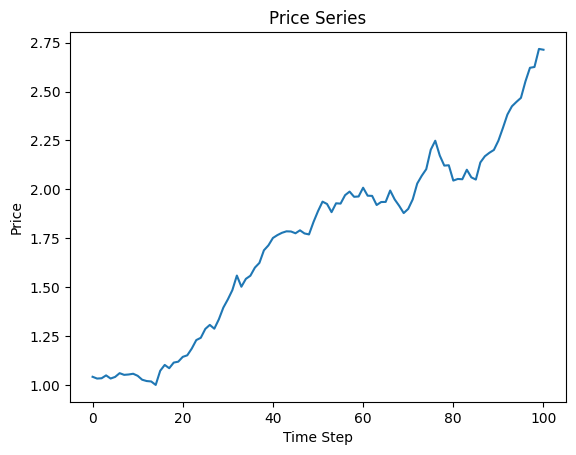

In [19]:
class TradingEnv(gym.Env):
    """
    Custom Environment for trading based on the autoregressive trend process.
    """
    def __init__(self, num_steps=100, lambda_param=3, kappa=0.9, transaction_cost=0.00075):
        super(TradingEnv, self).__init__()

        self.num_steps = num_steps
        self.lambda_param = lambda_param
        self.kappa = kappa
        self.transaction_cost = transaction_cost

        # Actions: 0 (Short), 1 (Neutral), 2 (Long)
        self.action_space = spaces.Discrete(3)

        # Observations: [price, trend_a, volatility_b]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(3,), dtype=np.float32)

    def reset(self):
        """
        Reset the environment to the initial state.
        """
        self.a = np.zeros(self.num_steps + 1)
        self.b = np.zeros(self.num_steps + 1)
        self.a[0] = 1
        self.b[0] = np.random.normal(0, 1)

        for k in range(1, self.num_steps + 1):
            self.a[k] = self.a[k-1] + self.b[k-1] + self.lambda_param * np.random.normal(0, 1)
            self.b[k] = self.kappa * self.b[k-1] + np.random.normal(0, 1)

        self.prices = np.exp((self.a - np.min(self.a)) / (np.max(self.a) - np.min(self.a)))

        self.current_step = 0
        self.position = 1  # Neutral
        self.total_reward = 0
        return self._get_observation()

    def step(self, action):
        """
        Take an action and return the new state, reward, and done flag.
        """

        prev_price = self.prices[self.current_step]
        self.current_step += 1
        done = self.current_step >= self.num_steps

        # Reward based on price change and position
        new_price = self.prices[self.current_step]
        reward = (new_price - prev_price) * (action - 1)  # Short (-1), Neutral (0), Long (+1)

        # Transaction cost
        if action != self.position:  # If action changes position
            reward -= self.transaction_cost * new_price
            reward -= 0.01 * abs(action - 1)  # Small penalty for neutral position

        self.position = action

        self.total_reward += reward
        return self._get_observation(), reward, done, {}

    def _get_observation(self):
        """
        Get the current state observation.
        """
        return np.array([self.prices[self.current_step], self.a[self.current_step], self.b[self.current_step]])

    def plot(self):
        """
        Plot the price series.
        """
        plt.plot(self.prices)
        plt.title("Price Series")
        plt.xlabel("Time Step")
        plt.ylabel("Price")
        plt.show()
        
# Test the environment
env = TradingEnv()
state = env.reset()
print("Initial State:", state)
env.plot()

In [ ]:
def generate_ohlc(tick_prices, steps_per_bar=60):
    """
    Aggregate tick data into OHLC bars.

    Parameters:
        tick_prices (list or np.array): Tick-level price data.
        steps_per_bar (int): Number of ticks per OHLC bar.
        60 ticks for 1min
        300 ticks for 5min
        900 ticks for 15min
        1800 ticks for 30min
        3600 ticks for 1hr
        14400 ticks for 4hr
        21600 ticks for 6hr
        28800 ticks for 8hr
        43200 ticks for 12hr
        86400 ticks for 1day

    Returns:
        pd.DataFrame: DataFrame containing OHLC data.
    """
    data = pd.DataFrame({'price': tick_prices})
    data['bar'] = data.index // steps_per_bar

    ohlc = data.groupby('bar')['price'].agg(
        open='first',
        high='max',
        low='min',
        close='last'
    ).reset_index()

    return ohlc

# Example usage with tick data
tick_prices = env.prices  # Tick-level price data from the environment
ohlc_data = generate_ohlc(tick_prices, steps_per_bar=10)  # Create 10-tick bars

print(ohlc_data.head())

   bar      open      high       low     close
0    0  1.062013  1.082552  1.014056  1.079550
1    1  1.107047  1.107047  1.041851  1.062041
2    2  1.067930  1.067930  1.000000  1.006822
3    3  1.008445  1.169796  1.008445  1.155048
4    4  1.165409  1.454336  1.165409  1.449600


In [24]:
class TradingEnvOHLC(TradingEnv):
    def __init__(self, num_steps=100, lambda_param=3, kappa=0.9, transaction_cost=0.01, steps_per_bar=5):
        super().__init__(num_steps, lambda_param, kappa, transaction_cost)
        self.steps_per_bar = steps_per_bar

    def reset(self):
        state = super().reset()
        self.ohlc_prices = self._generate_ohlc()
        return state

    def _generate_ohlc(self):
        return generate_ohlc(self.prices, self.steps_per_bar)

In [20]:
class PPOPolicy(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(PPOPolicy, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        policy = self.actor(x)
        value = self.critic(x)
        return policy, value


class PPOAgent:
    def __init__(self, state_dim, action_dim, lr=1e-4, gamma=0.99, clip_epsilon=0.1, update_steps=10):
        self.gamma = gamma
        self.clip_epsilon = clip_epsilon
        self.update_steps = update_steps

        self.policy = PPOPolicy(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)

    def compute_returns(self, rewards, dones, next_value):
        returns = []
        R = next_value
        for reward, done in zip(reversed(rewards), reversed(dones)):
            if done:
                R = 0
            R = reward + self.gamma * R
            returns.insert(0, R)
        return torch.tensor(returns, dtype=torch.float32)

    def update(self, states, actions, log_probs, returns, advantages):
        for _ in range(self.update_steps):
            new_log_probs, values = self.evaluate(states, actions)
            ratio = (new_log_probs - log_probs).exp()

            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()

            critic_loss = (returns - values).pow(2).mean()
            loss = actor_loss + 0.5 * critic_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def evaluate(self, states, actions):
        policies, values = self.policy(states)
        dist = torch.distributions.Categorical(policies)
        log_probs = dist.log_prob(actions)
        return log_probs, values.squeeze()

    def act(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        policy, _ = self.policy(state)
        dist = torch.distributions.Categorical(policy)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob.item()
    
    def load_model(agent, load_path):
        """
        Load a saved PPO model.

        Parameters:
            agent (PPOAgent): PPO agent instance.
            load_path (str): Path to the saved model file.
        """
        agent.policy.load_state_dict(torch.load(load_path))
        print(f"Model loaded from {load_path}")

In [21]:
def plot_convergence(rewards_per_episode):
    """
    Plot the convergence graph for PPO training.

    Parameters:
        rewards_per_episode (list): List of total rewards per episode.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(rewards_per_episode, label="Total Reward")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.title("Convergence of PPO Training")
    plt.legend()
    plt.grid()
    plt.show()

Episode 1/1000, Total Reward: 2.48
Episode 2/1000, Total Reward: 1.75
Episode 3/1000, Total Reward: 3.71
Episode 4/1000, Total Reward: 2.33
Episode 5/1000, Total Reward: 2.72
Episode 6/1000, Total Reward: 3.14
Episode 7/1000, Total Reward: 2.15
Episode 8/1000, Total Reward: 2.32
Episode 9/1000, Total Reward: 4.83
Episode 10/1000, Total Reward: 2.50
Episode 11/1000, Total Reward: 3.08
Episode 12/1000, Total Reward: 2.18
Episode 13/1000, Total Reward: 3.66
Episode 14/1000, Total Reward: 1.87
Episode 15/1000, Total Reward: 1.99
Episode 16/1000, Total Reward: 4.69
Episode 17/1000, Total Reward: 1.68
Episode 18/1000, Total Reward: 1.97
Episode 19/1000, Total Reward: 1.72
Episode 20/1000, Total Reward: 2.70
Episode 21/1000, Total Reward: 5.28
Episode 22/1000, Total Reward: 1.22
Episode 23/1000, Total Reward: 1.79
Episode 24/1000, Total Reward: 2.45
Episode 25/1000, Total Reward: 4.41
Episode 26/1000, Total Reward: 1.60
Episode 27/1000, Total Reward: 2.26
Episode 28/1000, Total Reward: 1.83
E

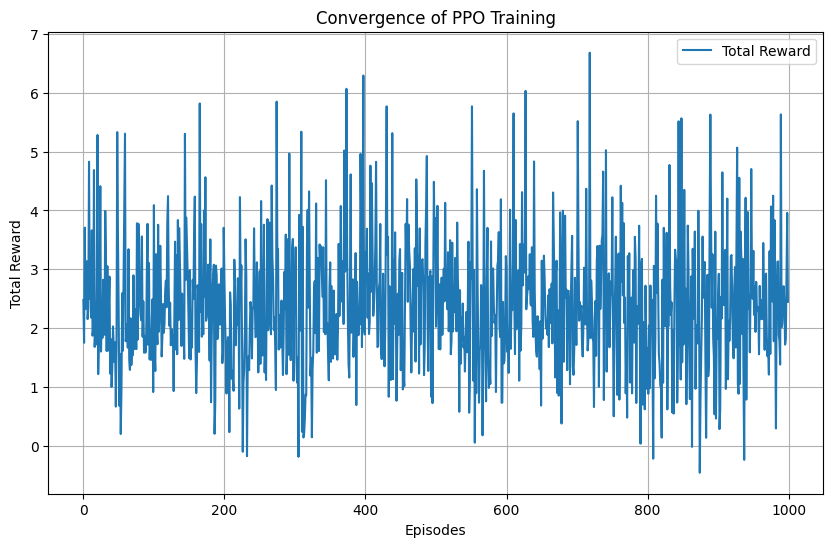

Final model saved to ppo_trading_model.pth


In [22]:
def train_ppo(env, agent, num_episodes=1000, max_steps=100, save_path="ppo_trading_model.pth"):
    rewards_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()
        states, actions, rewards, log_probs, dones = [], [], [], [], []

        for t in range(max_steps):
            action, log_prob = agent.act(state)
            next_state, reward, done, _ = env.step(action)

            # Record data
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            log_probs.append(log_prob)
            dones.append(done)

            state = next_state
            if done:
                break

        # Compute returns and advantages
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64)
        log_probs = torch.tensor(log_probs, dtype=torch.float32)
        returns = agent.compute_returns(rewards, dones, 0)
        advantages = returns - agent.policy.critic(states).detach()

        # Update PPO policy
        agent.update(states, actions, log_probs, returns, advantages)

        # Store total reward
        total_reward = sum(rewards)
        rewards_per_episode.append(total_reward)

        # Print progress
        print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward:.2f}")

        # Save the model periodically
        if (episode + 1) % 100 == 0:
            torch.save(agent.policy.state_dict(), save_path)
            print(f"Model saved to {save_path}")

    # Plot convergence
    plot_convergence(rewards_per_episode)

    # Save final model
    torch.save(agent.policy.state_dict(), save_path)
    print(f"Final model saved to {save_path}")

train_ppo(env, agent, num_episodes=1000, max_steps=100, save_path="ppo_trading_model.pth")

In [ ]:
# Load the saved model
load_model(agent, "ppo_trading_model.pth")

# Test the loaded model
state = env.reset()
done = False
total_reward = 0

while not done:
    action, _ = agent.act(state)
    state, reward, done, _ = env.step(action)
    total_reward += reward

print(f"Total Reward with Loaded Model: {total_reward:.2f}")